In [22]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import cv2
from pycocotools.coco import COCO
import datetime as dt

import seaborn as sns

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision import transforms, utils
from torchvision.transforms.transforms import RandomAutocontrast, Grayscale, RandomRotation, RandomPerspective, RandomInvert
from torchvision.transforms import Resize
from torchvision.io import read_image, ImageReadMode
from torch import nn

import skimage.io as io

import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix

import plotly.io as pio
from plotly.figure_factory import create_annotated_heatmap

plt.ion()

In [23]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [25]:
TRAIN_SIZE = .75
BATCH_SIZE = 16
#T_BATCH_SIZE = 10
#IMG_SIZE = 512
#IMG_CHANNELS = 1
dataDir='drive/MyDrive/Colab Notebooks/samolet/data/images/'
dataType='default'
annFile='{}annotations/instances_{}.json'.format(dataDir,dataType)

In [26]:
coco = COCO(annFile)
cats = coco.loadCats(coco.getCatIds())
nms=[cat['name'] for cat in cats]
print('COCO categories: \n{}\n'.format(' '.join(nms)))

nms = set([cat['supercategory'] for cat in cats])
print('COCO supercategories: \n{}'.format(' '.join(nms)))

loading annotations into memory...
Done (t=0.56s)
creating index...
index created!
COCO categories: 
window empty filled

COCO supercategories: 



Тут пока костыли. Датасет из коко собирается, но что делать с контурами пока не знаю, а потому пересобираю датасет из изображений и меток

In [27]:
cococo = datasets.CocoDetection(root = dataDir, annFile = 'drive/MyDrive/Colab Notebooks/samolet/data/images/annotations/instances_default.json')
images = []
labels = []
boxes = []
for img, data in cococo:
  images.append(img)
  labels.append(data[0]['category_id'])
  boxes.append(data[0]['bbox'])

loading annotations into memory...
Done (t=0.53s)
creating index...
index created!


In [28]:
image_names = []
for filename in os.listdir(dataDir):
  if 'jpg' in filename.lower():
    image_names.append(filename)
descr = pd.DataFrame(data={
    'file': image_names,
    'target': labels})
descr['target'] = descr['target'] - 1

In [29]:
descr.head()

,file,target
0,0000002399building.jpg,1
1,0000034487building.jpg,1
2,0000035088building.jpg,1
3,0000012931building.jpg,0
4,0000013622building.jpg,1


In [30]:
class bld(Dataset):
    def __init__(self, annotations, img_dir, transform, target_transform=None):
        self.img_labels = annotations
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        #image = preprocessing(img_path)
        image = read_image(img_path, ImageReadMode.RGB).to(torch.float32)
        label = np.uint8(self.img_labels.iloc[idx, 1])
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

Дальше пока какая-то случайная аугментация

In [31]:
transformer = transforms.Compose([
    transforms.Resize((256, 256)),
    #Grayscale(3), RandomAutocontrast(),
    RandomRotation(90), RandomPerspective(),
    RandomInvert()]
)
imgs = bld(annotations=descr, img_dir=dataDir, transform=transformer)
train_size = int(TRAIN_SIZE * len(imgs))
valid_size = len(imgs) - train_size
train_dataset, valid_dataset = torch.utils.data.random_split(imgs, [train_size, valid_size])

In [32]:
look_flow = DataLoader(imgs, batch_size=8, shuffle=True, num_workers=1,
                           pin_memory=True)

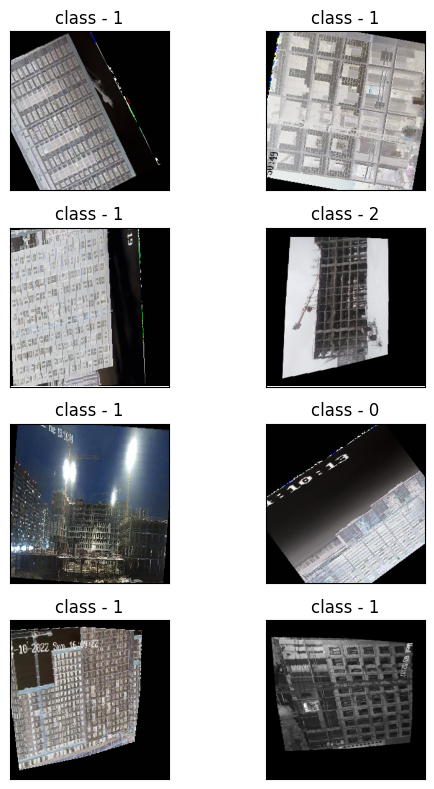

In [33]:
fig = plt.figure(figsize=(8,8))
for IMG, label in (look_flow):
    for i in range(8):
        fig.add_subplot(4, 2, i+1)
        plt.imshow(IMG[i].to(torch.uint8).permute(1, 2, 0))
        plt.title(f'class - {label[i]}')
        plt.xticks([])
        plt.yticks([])
        plt.tight_layout()
    break

И просто на попробовать что-то небольшое и сверточное

In [34]:
class MyNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(3, 6, (5,5)),
            nn.ReLU(),
            nn.AvgPool2d(5, stride=1),
            nn.Conv2d(6, 9, (5,5)),
            nn.ReLU(),
            nn.AvgPool2d(5, stride=1),
            nn.Conv2d(9, 18, (5,5)),
            nn.ReLU(),
            nn.AvgPool2d(5, stride=1),
            #nn.Conv2d(64, 128, (5,5)),
            #nn.ReLU(),
            #nn.AvgPool2d(5, stride=2),
            nn.Flatten(),
            #nn.LazyLinear(1024),
            #nn.Tanh(),
            nn.LazyLinear(128),
            nn.Tanh(),
            nn.LazyLinear(32),
            nn.ReLU(),
            nn.LazyLinear(3),
            nn.Softmax()
        )
        #self.float()

    def forward(self, x):
        return self.layers(x)

model = MyNN().to(device)
print(model)

MyNN(
  (layers): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): AvgPool2d(kernel_size=5, stride=1, padding=0)
    (3): Conv2d(6, 9, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): AvgPool2d(kernel_size=5, stride=1, padding=0)
    (6): Conv2d(9, 18, kernel_size=(5, 5), stride=(1, 1))
    (7): ReLU()
    (8): AvgPool2d(kernel_size=5, stride=1, padding=0)
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): LazyLinear(in_features=0, out_features=128, bias=True)
    (11): Tanh()
    (12): LazyLinear(in_features=0, out_features=32, bias=True)
    (13): ReLU()
    (14): LazyLinear(in_features=0, out_features=3, bias=True)
    (15): Softmax(dim=None)
  )
)


In [35]:
train_flow = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=1,
                           pin_memory=True)
valid_flow = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=1,
                           pin_memory=True)

In [36]:
print(descr['target'].unique())

[1 0 2]


In [37]:
w_1 = 0
w_2 = 0
w_0 = 0
for i in range(len(train_dataset)):
  if train_dataset[i][1] == 1:
    w_1 += 1
  elif train_dataset[i][1] == 2:
    w_2 += 1
  else:
    w_0 += 1
print(w_1 / len(train_dataset), w_2 / len(train_dataset), w_0 / len(train_dataset))

0.47619047619047616 0.30158730158730157 0.2222222222222222


На баланс классов пока внимание не обращаю

In [38]:
del w_1, w_2, w_0, images, cococo

Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14


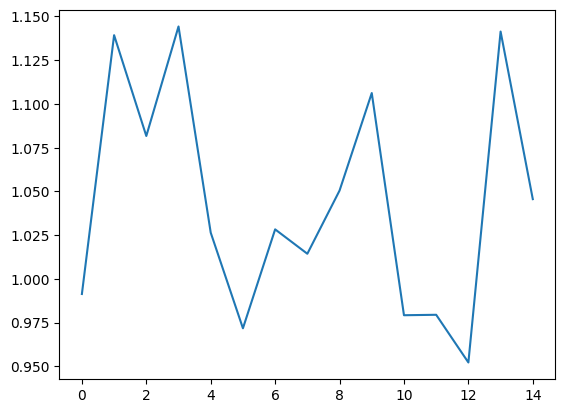

In [39]:
model = MyNN()
#pos_weight=torch.tensor(np.array([POS_WEIGHT]))
loss_t = nn.CrossEntropyLoss()
loss_v = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_graph = []

n_epochs = 15
for epoch in range(n_epochs):
    train_features, train_labels = next(iter(train_flow))

    y_pred = model(train_features)
    loss = loss_t(y_pred, train_labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    CE = 0
    valid_features, valid_labels = next(iter(valid_flow))

    y_pred = model(valid_features)
    CE = loss_v(y_pred, valid_labels)
    loss_graph.append(CE.detach().numpy())
    probs = torch.sigmoid(y_pred)
    #pre = precision_score(valid_labels.detach().numpy(), y_pred.detach().numpy().round(), average='micro')
    #rec = recall_score(valid_labels.detach().numpy(), y_pred.detach().numpy().round(), average=None)
    #acc = accuracy_score(valid_labels.detach().numpy(), y_pred.detach().numpy().round())

    print(f'Epoch: {epoch}')# --- PRECISION {pre} --- RECALL {rec} --- ACCURACY {acc}')
plt.plot(loss_graph)

которая пока так себе учится,, но это и не очень важно пока))

И просто на попробовать поиск контуров

In [40]:
def preprocessing(path):
  img_in = cv2.imread(path)
  img = cv2.resize(img_in, (512, 512), interpolation = cv2.INTER_AREA)
  imgray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  ret, thresh = cv2.threshold(imgray, 127, 255, 0)
  contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  img_contours = np.uint8(np.zeros((img.shape[0],img.shape[1])))
  cont = cv2.drawContours(img_contours, contours, -1, (255,255,255), 1)
  return torch.tensor(cont, dtype=torch.float32), cont, img_in

In [41]:
path_list = []
for i in [42, 14, 88, 69]:
  path_list.append('drive/MyDrive/Colab Notebooks/samolet/data/images/' + descr['file'][i])

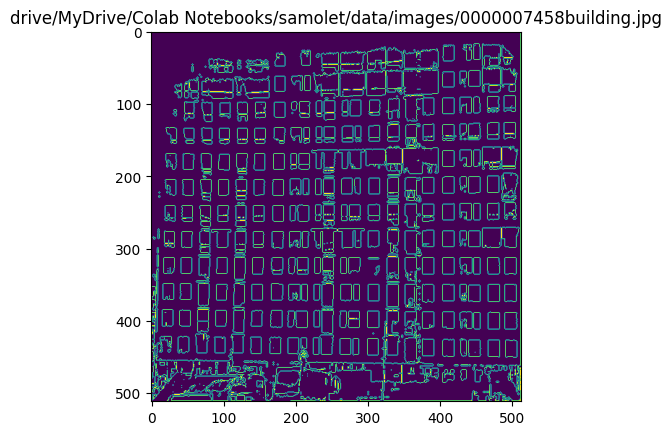

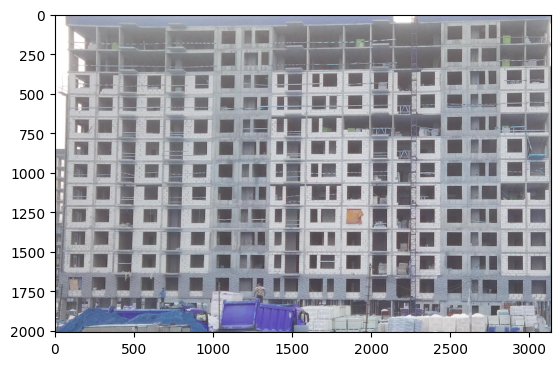

___________-


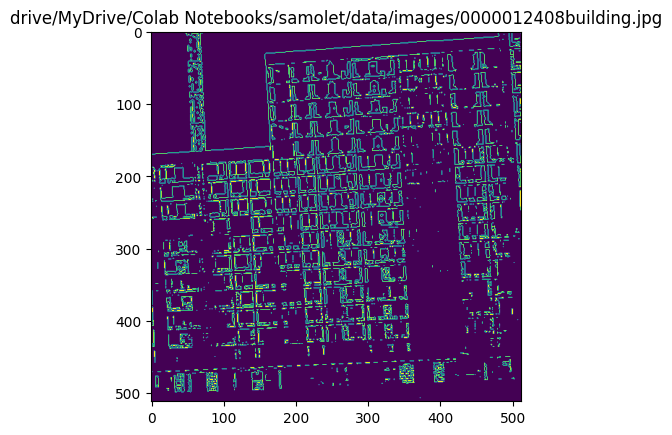

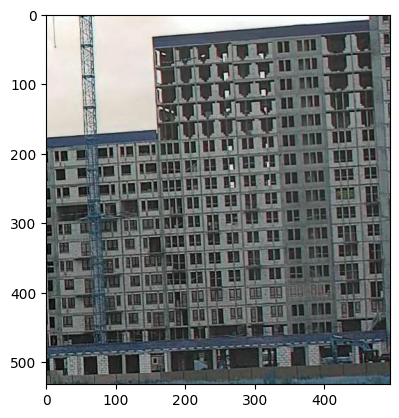

___________-


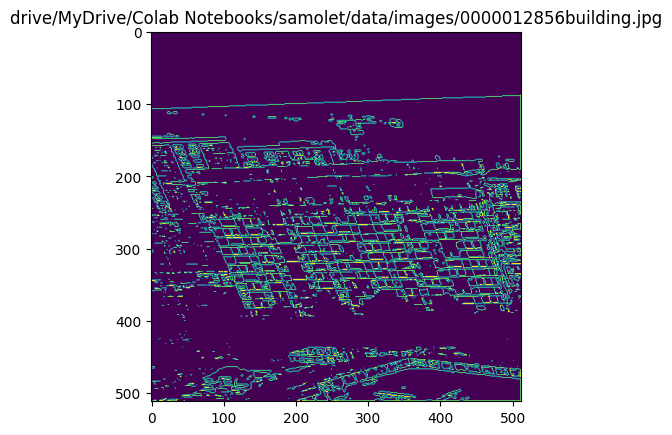

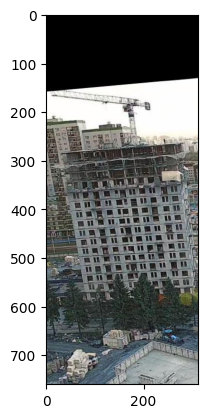

___________-


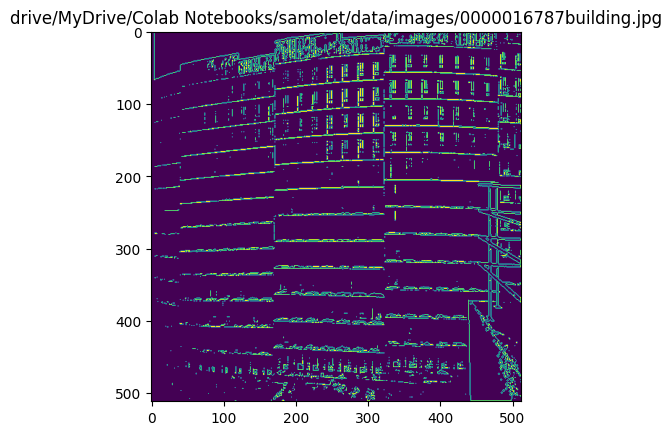

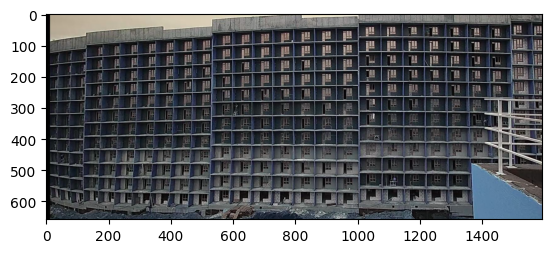

___________-


In [42]:
for p in path_list:
  plt.title(p)
  plt.imshow(preprocessing(p)[1])
  plt.show()
  plt.imshow(preprocessing(p)[2])
  plt.show()
  print('___________-')

а вот это уже интереснее. но потом